<a href="https://colab.research.google.com/github/sueprim/stock_predict_model/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Price                         Close
Ticker                    035900.KQ
Date                               
2002-07-01 00:00:00+00:00   60000.0
2002-07-02 00:00:00+00:00   62500.0
2002-07-03 00:00:00+00:00   65000.0
2002-07-04 00:00:00+00:00   65500.0
2002-07-05 00:00:00+00:00   65000.0
Epoch 1/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0017
Epoch 2/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1374e-04
Epoch 3/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 1.1285e-04
Epoch 4/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 1.4157e-04
Epoch 5/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 1.0853e-04
Epoch 6/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 7.7638e-05
Epoch 7/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 1.1448e-04
Epoch 8/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 8.6234e-05
Epoch 9/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 8.0542e-05
Epoch 10/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/ste

<ipython-input-1-e928afa79fb1>:87: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2024-01-01', periods=future_steps, freq='M')


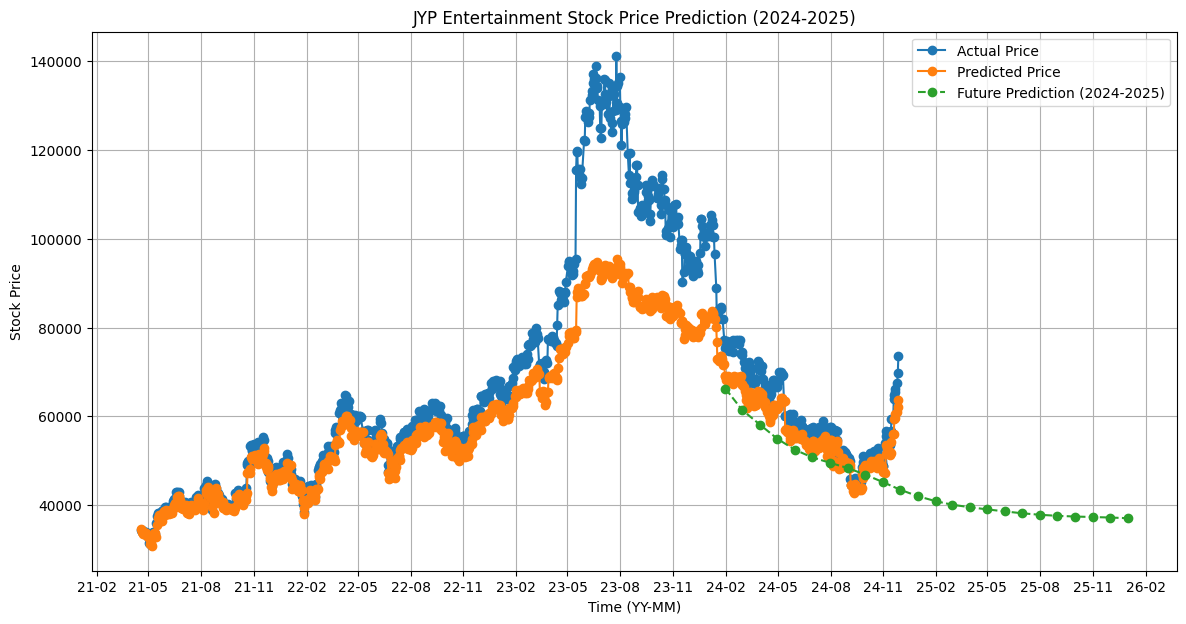

In [ ]:
# 필요한 라이브러리 설치
!pip install yfinance matplotlib scikit-learn tensorflow

# 라이브러리 가져오기
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from datetime import timedelta
import matplotlib.dates as mdates

# 1. 데이터 다운로드
stock_symbol = '035900.KQ'  # JYP 엔터테인먼트 KOSDAQ 코드
today = pd.Timestamp.today().strftime('%Y-%m-%d')
data = yf.download(stock_symbol, start='2000-01-01', end=today)

# 'Close' 가격만 사용
data = data[['Close']]

# 결측치 확인 및 제거
data.dropna(inplace=True)

# 데이터 확인
print(data.head())

# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 학습 데이터 분리
time_step = 60  # 60일 데이터를 기반으로 다음 날 예측
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len:]

# 데이터셋 생성 함수
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# LSTM 입력 형식으로 데이터 변환
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3. 모델 생성
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 4. 모델 학습
model.fit(X_train, y_train, batch_size=32, epochs=200)

# 5. 테스트 데이터 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # 예측값 역정규화
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. 미래 예측 (2024-01 ~ 2025-12)
future_steps = 24  # 24개월 예측
future_predictions = []
current_input = scaled_data[-time_step:].reshape(1, time_step, 1)

for _ in range(future_steps):
    next_pred = model.predict(current_input)
    future_predictions.append(next_pred[0, 0])
    current_input[:, :-1, :] = current_input[:, 1:, :]
    current_input[:, -1, :] = next_pred

# 미래 예측 데이터 역정규화
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 미래 날짜 생성
future_dates = pd.date_range(start='2024-01-01', periods=future_steps, freq='M')

# 7. 시각화
plt.figure(figsize=(14, 7))

# 실제 값과 예측 값
plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Actual Price', marker='o')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted Price', marker='o')

# 미래 예측 값
plt.plot(future_dates, future_predictions, label='Future Prediction (2024-2025)', marker='o', linestyle='--')

# X축 포맷 변경
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 간격
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))  # YY-MM 형식

# 제목과 레이블
plt.title('JYP Entertainment Stock Price Prediction (2024-2025)')
plt.xlabel('Time (YY-MM)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()
